In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import glob
import matplotlib.pyplot as plt
from transformers import TFAutoModel
import tensorflow_addons as tfa
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

Dataset Imported from "https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset"

In [ ]:
def serialize_example(image,label):
    feature = {
               'image': tf.train.Feature(bytes_list = tf.train.BytesList(value = [image])),
               'label':tf.train.Feature(bytes_list = tf.train.BytesList(value = [label])),
               }

    feature = tf.train.Example(features = tf.train.Features(feature = feature))
    return feature.SerializeToString()
def write_records(df,path):
    with tf.io.TFRecordWriter(path) as writer:
        for img,label in df.values:
            img = open(img,'rb').read()
            if label == 'MildDemented':
                label = np.array([0,0,1,0],dtype = np.float32)
            elif label == 'ModerateDemented':
                label = np.array([0,0,0,1],dtype = np.float32)
            elif label == 'NonDemented':
                label = np.array([1,0,0,0],dtype = np.float32)
            elif label == 'VeryMildDemented':
                label = np.array([0,1,0,0],dtype = np.float32)    
            label = tf.io.serialize_tensor(label).numpy()
            example = serialize_example(img,label)
            writer.write(example)

In [ ]:
def return_data_labels(label):
    files = glob.glob("/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/"+label+"/*")
    df = pd.DataFrame({'filename':files,'label':[label]*len(files)})
    df = df.sample(6000,random_state = 142)
    return df

In [ ]:
mild = return_data_labels("MildDemented")
mod = return_data_labels("ModerateDemented")
non = return_data_labels("NonDemented")
vmild = return_data_labels("VeryMildDemented")

In [ ]:
def return_splits_ttv(data):
    train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
    test_data, val_data = train_test_split(test_data, test_size=0.8, random_state=42)
    return train_data,test_data,val_data

def splits():
    trainmild,testmild,valmild = return_splits_ttv(mild)
    trainmod,testmod,valmod = return_splits_ttv(mod)
    trainv,testv,valv = return_splits_ttv(vmild)
    trainn,testn,valn = return_splits_ttv(non)
    train = pd.concat([trainv,trainn,trainmild,trainmod])
    test = pd.concat([testv,testn,testmild,testmod])
    val = pd.concat([valv,valn,valmild,valmod])
    return train,test,val

In [ ]:
train,test,val = splits()

In [ ]:
train.groupby('label').count()

,filename
label,
MildDemented,5100
ModerateDemented,5100
NonDemented,5100
VeryMildDemented,5100


In [ ]:
test.groupby('label').count()

,filename
label,
MildDemented,180
ModerateDemented,180
NonDemented,180
VeryMildDemented,180


In [ ]:
val.groupby('label').count()

,filename
label,
MildDemented,720
ModerateDemented,720
NonDemented,720
VeryMildDemented,720


In [ ]:
write_records(train,"/kaggle/working/train_rec")
write_records(test,"/kaggle/working/test_rec")
write_records(val,"/kaggle/working/val_rec")

In [ ]:
def parse_sample(example):
    feature = {'image':tf.io.FixedLenFeature([],tf.string),
              'label':tf.io.FixedLenFeature([],tf.string)}
    features = tf.io.parse_single_example(example,feature)
    image = tf.io.decode_jpeg(features['image'],channels = 3)
    image = tf.image.resize(image,[128,128])
    image = tf.keras.layers.Rescaling(1./255)(image)
    label = tf.io.parse_tensor(features['label'],out_type = tf.float32)
    label = tf.reshape(label,(4,))
    return image,label
def read_dataset(ds):
    ds = tf.data.TFRecordDataset(ds)
    ds = ds.map(parse_sample,num_parallel_calls = tf.data.experimental.AUTOTUNE)
    ds = ds.shuffle(700)
    ds = ds.batch(32,drop_remainder = True)
    ds = ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
train_ds = read_dataset("/kaggle/working/train_rec")
test_ds = read_dataset("/kaggle/working/test_rec")
val_ds = read_dataset("/kaggle/working/val_rec")

In [ ]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None))>

Very Mild Alzheimer


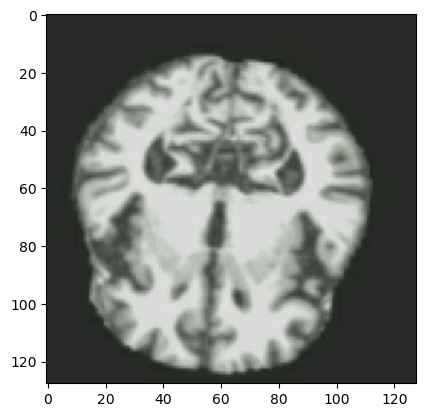

In [ ]:
tf.random.set_seed(102)
for image,label in test_ds.take(1):
    plt.imshow(tf.squeeze(image[29].numpy()))
    if list(label[29].numpy())== [0,0,1,0]:
                label = "Mild Alzheimer"
    elif list(label[29].numpy())== [0,0,0,1] :
                label = "Moderate Alzheimer"
    elif list(label[29].numpy())== [1,0,0,0]:
                label = "No Alzheimer"
    elif list(label[29].numpy()) == [0,1,0,0]:
                label = "Very Mild Alzheimer"
    print(label)      

In [ ]:
def create_model():
    ip_tensor = tf.keras.Input(batch_size = 32,shape = (128,128,3))
    vgg = tf.keras.applications.vgg19.VGG19(input_tensor = ip_tensor, weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    output = tf.keras.layers.Flatten()(vgg.output)
    output = tf.keras.layers.Dropout(0.27)(output)
    output = tf.keras.layers.Dense(4, activation='softmax')(output)
    model = tf.keras.Model(inputs=vgg.input, outputs=output)
    return model

In [ ]:
model = create_model()
model.summary()

Model: "model_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_124 (InputLayer)      [(32, 128, 128, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (32, 128, 128, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (32, 128, 128, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (32, 64, 64, 64)          0         
                                                                 
 block2_conv1 (Conv2D)       (32, 64, 64, 128)         73856     
                                                                 
 block2_conv2 (Conv2D)       (32, 64, 64, 128)         147584    
                                                                 
 block2_pool (MaxPooling2D)  (32, 32, 32, 128)         0 

In [ ]:
model.set_weights(best.weights)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.000002),
              loss=tf.losses.CategoricalCrossentropy()
              ,metrics=[tf.keras.metrics.AUC(name='auc'),'accuracy'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience = 1,min_delta=0.0005)]

In [ ]:
his = model.fit(train_ds,validation_data = val_ds,epochs = 20,callbacks = callbacks)

Epoch 1/20
637/637 [==============================] - 22s 35ms/step - loss: 1.2375 - auc: 0.8989 - accuracy: 0.7206 - val_loss: 1.0560 - val_auc: 0.9126 - val_accuracy: 0.7427
Epoch 2/20
637/637 [==============================] - 22s 34ms/step - loss: 1.2359 - auc: 0.8982 - accuracy: 0.7208 - val_loss: 1.0541 - val_auc: 0.9128 - val_accuracy: 0.7424


In [ ]:
def evaluate(ds):
    results = list(model.evaluate(ds,verbose = 0))
    print("AUC Score : ",results[1]*100)
    print("Accuracy Score : ",results[2]*100)

In [ ]:
evaluate(val_ds)

AUC Score :  91.27744436264038
Accuracy Score :  74.23611283302307


In [ ]:
evaluate(test_ds)

AUC Score :  91.56133532524109
Accuracy Score :  74.00568127632141


In [ ]:
model.save_weights("/kaggle/working/highest_weights")